# XGBoost Implementation


In [197]:
from google.colab import files
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,f1_score
from imblearn.over_sampling import SMOTE
from collections import Counter
import shap
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import ADASYN ,SMOTE
from imblearn.combine import SMOTEENN

In [13]:
# files.upload()

In [14]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [15]:
# !pip install kaggle

In [16]:
# !kaggle datasets download milapgohil/flavorsense-tastes-predicted-by-life-and-climate

In [17]:
# !unzip flavorsense-tastes-predicted-by-life-and-climate.zip -d flavorsense

In [18]:
df = pd.read_csv("flavorsense/FlavorSense.csv")
df.head(5)

,age,sleep_cycle,exercise_habits,climate_zone,historical_cuisine_exposure,preferred_taste
0,56.0,Irregular,Heavy,Temperate,NaN,Salty
1,NaN,Night Owl,Heavy,Temperate,Asian,Sweet
2,46.0,Night Owl,Heavy,Cold,Mixed,Sour
3,32.0,Early Bird,Heavy,Cold,Mediterranean,Salty
4,60.0,Night Owl,Moderate,Dry,Mediterranean,Sour


In [19]:
df.shape

(10000, 6)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   age                          9032 non-null   float64
 1   sleep_cycle                  9316 non-null   object 
 2   exercise_habits              9196 non-null   object 
 3   climate_zone                 9467 non-null   object 
 4   historical_cuisine_exposure  9346 non-null   object 
 5   preferred_taste              10000 non-null  object 
dtypes: float64(1), object(5)
memory usage: 468.9+ KB


In [204]:
df.columns

Index(['age', 'sleep_cycle', 'exercise_habits', 'climate_zone',
       'historical_cuisine_exposure', 'preferred_taste'],
      dtype='object')

# Introduction

The purpose of this notebook is to explore the power of XGBoost (extream gradient boosting algortithm) through practical application

- The choice of dataset was to apply and explain the algorithm real world inspired dataset that predicts peoples tastes(spicy, sweet , sour, salty) based on their lifstyle habits
which is engaging and relatable
- Exploration of multi class classification problem which is perfect to test XGBoost ability to handle complex patterns
- The data is big enough to show complex patterns, and small enough to train quickly for light explaination
- One of the advantages of XGBoost is that it handels missing values efficienlty we will explore that
- explore how the algorithm does with duplicates and without


# EDA

In [21]:
df.isna().sum()/df.shape[0]*100

,0
age,9.68
sleep_cycle,6.84
exercise_habits,8.04
climate_zone,5.33
historical_cuisine_exposure,6.54
preferred_taste,0.00


In [22]:
df.duplicated().sum()

np.int64(3676)

In [23]:
df.drop_duplicates(inplace=True)

In [24]:
df.duplicated().sum()

np.int64(0)

In [25]:
df.shape

(6324, 6)

In [26]:
cat_f = df.select_dtypes("O").columns.to_list()
num_f = df.select_dtypes(exclude = "O").columns.to_list()

In [27]:
cat_f

['sleep_cycle',
 'exercise_habits',
 'climate_zone',
 'historical_cuisine_exposure',
 'preferred_taste']

In [28]:
num_f

['age']

## Categorical features

In [29]:
for col in cat_f:
  print(f"Num of Unique values in {col} : {df[col].unique()}\n")

Num of Unique values in sleep_cycle : ['Irregular' 'Night Owl' 'Early Bird' nan]

Num of Unique values in exercise_habits : ['Heavy' 'Moderate' 'Light' nan]

Num of Unique values in climate_zone : ['Temperate' 'Cold' 'Dry' 'Tropical' nan]

Num of Unique values in historical_cuisine_exposure : [nan 'Asian' 'Mixed' 'Mediterranean']

Num of Unique values in preferred_taste : ['Salty' 'Sweet' 'Sour' 'Spicy']



In [30]:
for col in cat_f[:-1]:
  df[col] = df[col].replace({np.nan : "missing"})

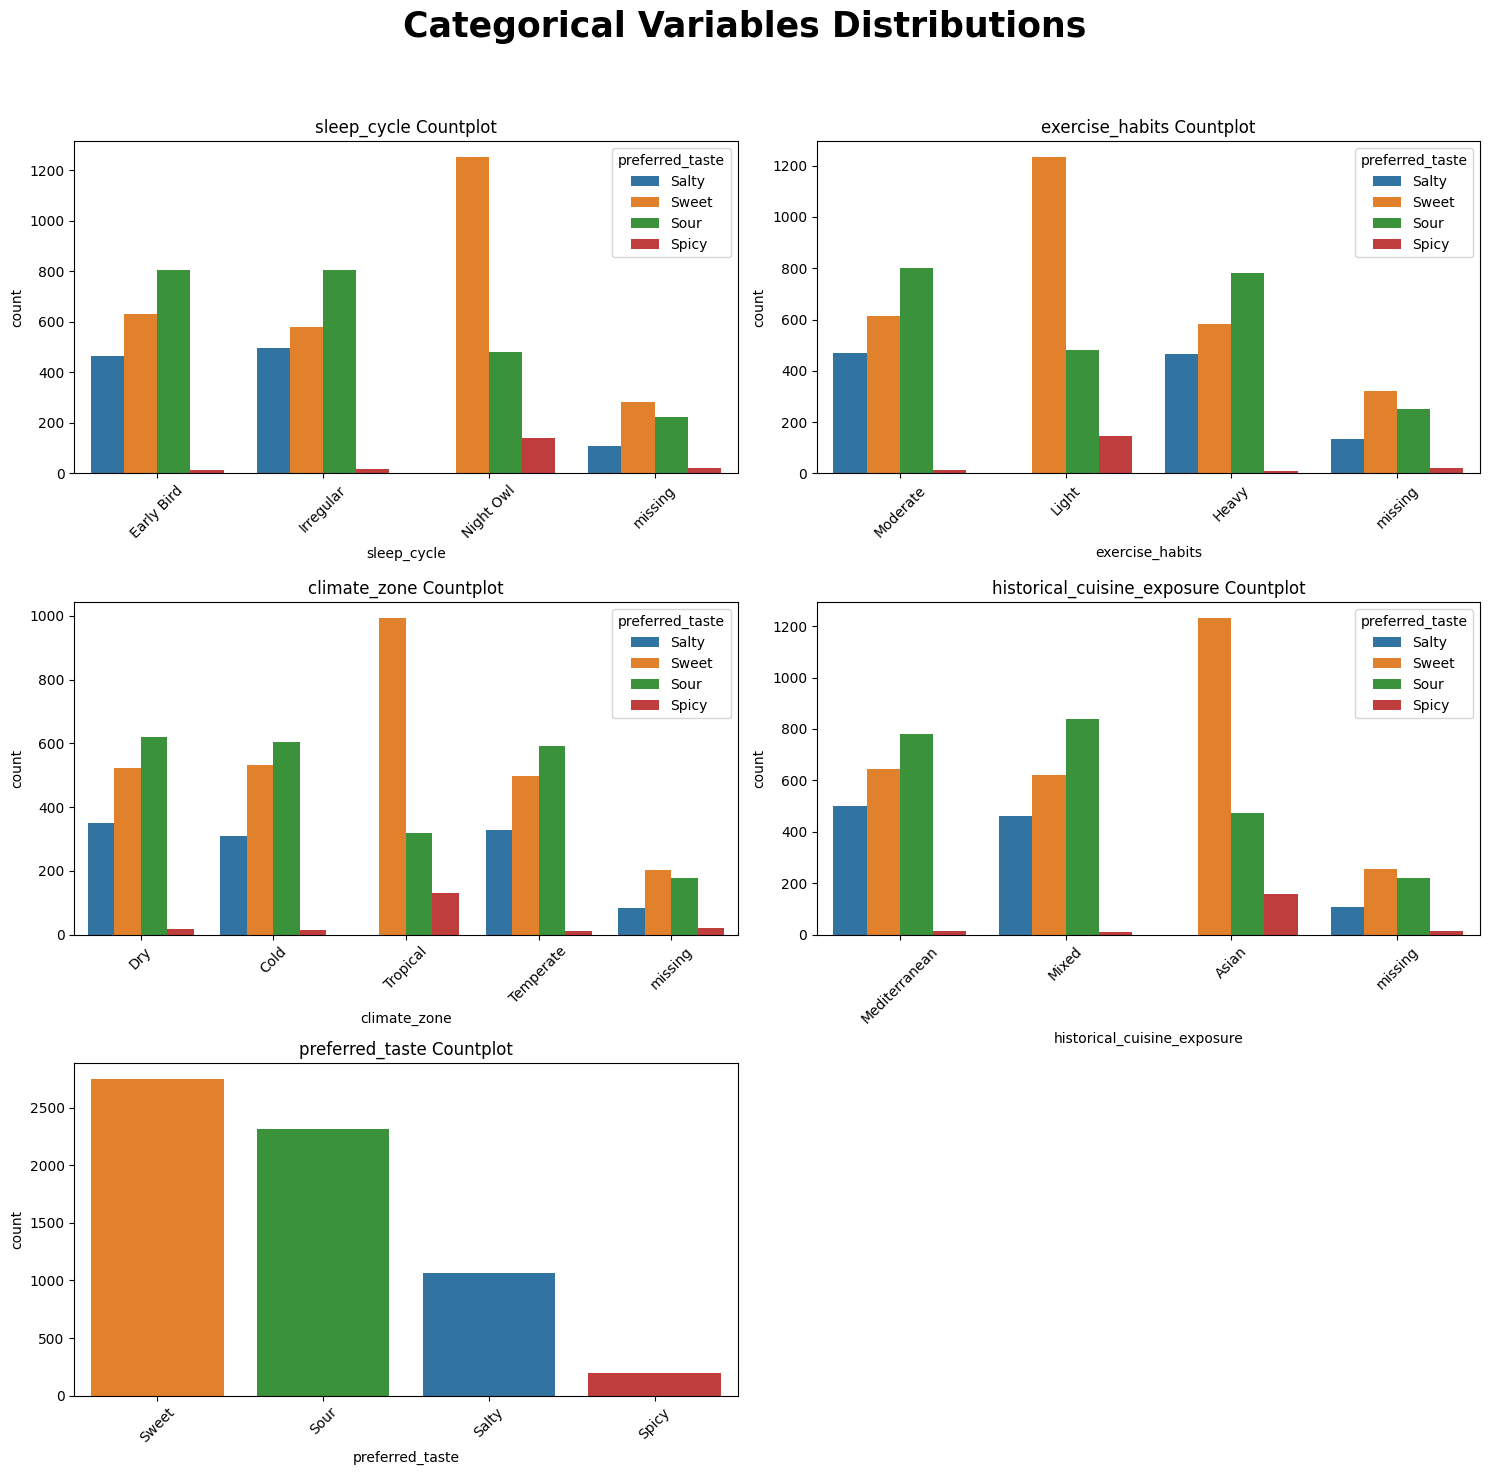

In [31]:
plt.figure(figsize=(15, 15))
palette = sns.color_palette("Set2", n_colors=len(cat_f))
for i, col in enumerate(cat_f):
    plt.subplot(3, 2, i+1)
    order = df[col].value_counts().index
    sns.countplot(data=df, x=col, order = order , hue = 'preferred_taste')
    plt.title(f"{col} Countplot")
    plt.xticks(rotation=45)

plt.suptitle("Categorical Variables Distributions", fontsize=25, weight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.95])

- Data is severly unbalanced (if not treated correctly the model may overfit)



<Axes: xlabel='age'>

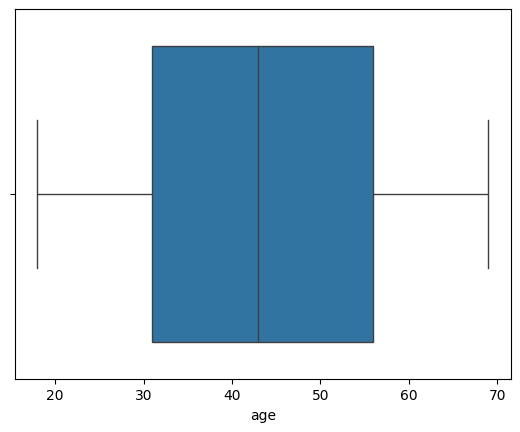

In [32]:
sns.boxplot(data = df, x= 'age')

<Axes: xlabel='age', ylabel='Count'>

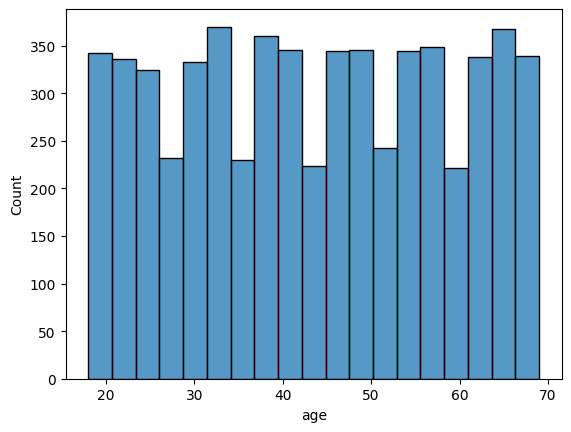

In [196]:
sns.histplot(data = df, x= 'age')

## Preprocessing

- ONEHOTENCODER for categorical data
- Label encoder for label
- Fill Nan values => numeric(mean), categorical ("missing")
- Use Smote for data balancing (removed it didnt improve the score)


In [140]:
x = df.drop('preferred_taste', axis = 1)
y = df['preferred_taste']

In [141]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y,random_state=42, stratify=y, test_size=0.20)

In [142]:
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
xtrainenc = ohe.fit_transform(xtrain[cat_f[:-1]])
xtestenc = ohe.transform(xtest[cat_f[:-1]])

In [143]:
dftrainenc = pd.DataFrame(xtrainenc,
                          columns=ohe.get_feature_names_out(cat_f[:-1]),
                          index=xtrain.index)
dftestenc = pd.DataFrame(xtestenc,
                          columns=ohe.get_feature_names_out(cat_f[:-1]),
                          index=xtest.index)
xtrain.drop(cat_f[:-1], axis =1, inplace=True)
xtest.drop(cat_f[:-1], axis =1, inplace=True)
xtrain = pd.concat([xtrain, dftrainenc], axis=1)
xtest = pd.concat([xtest, dftestenc], axis=1)

In [144]:
xtrain.shape

(5059, 18)

In [145]:
le = LabelEncoder()
ytrain = le.fit_transform(ytrain)
ytest = le.transform(ytest)

In [44]:
# xtrain.head(5)

In [45]:
# xtest.head(2)



---



---



---



In [146]:
agemean = round(xtrain['age'].mean())
xtrain['age'] = xtrain['age'].fillna(agemean)
xtest['age'] = xtest['age'].fillna(agemean)

In [148]:
print(Counter(ytrain))

Counter({np.int64(3): 2199, np.int64(1): 1852, np.int64(0): 854, np.int64(2): 154})


In [131]:
# smote = ADASYN(random_state=42)
# X_train_res, y_train_res = smote.fit_resample(xtrain, ytrain)

In [132]:
# Counter(y_train_res)

In [225]:
# X_train_res

## Model

In [158]:
param = {
    "n_estimators": [100, 200, 300, 400],
    "max_depth": [3, 5, 7, 9],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.3, 0.5]
}

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [159]:
# random_search = RandomizedSearchCV(
#     estimator=XGBClassifier(objective="multi:softmax", num_class=4, eval_metric="mlogloss",use_label_encoder=False),
#     param_distributions=param,
#     n_iter=30,
#     scoring="f1_weighted",
#     cv=cv,
#     n_jobs=-1,
#     verbose=2,
#     random_state=42
# )

In [160]:
# random_search.fit(xtrain, ytrain)

# print("Best Params:", random_search.best_params_)
# print("Best CV Score:", random_search.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [13:42:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Params: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.6}
Best CV Score: 0.8982670062652893


In [200]:
model = XGBClassifier(
    objective="multi:softmax",
    num_class = 4,
    eval_metric="mlogloss",
    random_state=42,
    colsample_bytree=0.6,
    gamma=0.3,
    learning_rate=0.05,
    max_depth=3,
    n_estimators=300,
    subsample=1.0,
    n_jobs=-1
)
model.fit(xtrain, ytrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=0.3,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1, num_class=4, ...)

In [201]:
ytrain_pred = model.predict(xtrain)
ytest_pred = model.predict(xtest)
print("\nClassification Report (Train):\n", classification_report(ytrain, ytrain_pred))
print("\nClassification Report (Test):\n", classification_report(ytest, ytest_pred))


Classification Report (Train):
               precision    recall  f1-score   support

           0       0.83      1.00      0.91       854
           1       0.86      0.91      0.88      1852
           2       1.00      0.68      0.81       154
           3       0.97      0.88      0.92      2199

    accuracy                           0.90      5059
   macro avg       0.92      0.86      0.88      5059
weighted avg       0.91      0.90      0.90      5059


Classification Report (Test):
               precision    recall  f1-score   support

           0       0.80      1.00      0.89       214
           1       0.83      0.87      0.85       463
           2       1.00      0.71      0.83        38
           3       0.96      0.84      0.90       550

    accuracy                           0.87      1265
   macro avg       0.90      0.86      0.87      1265
weighted avg       0.88      0.87      0.87      1265



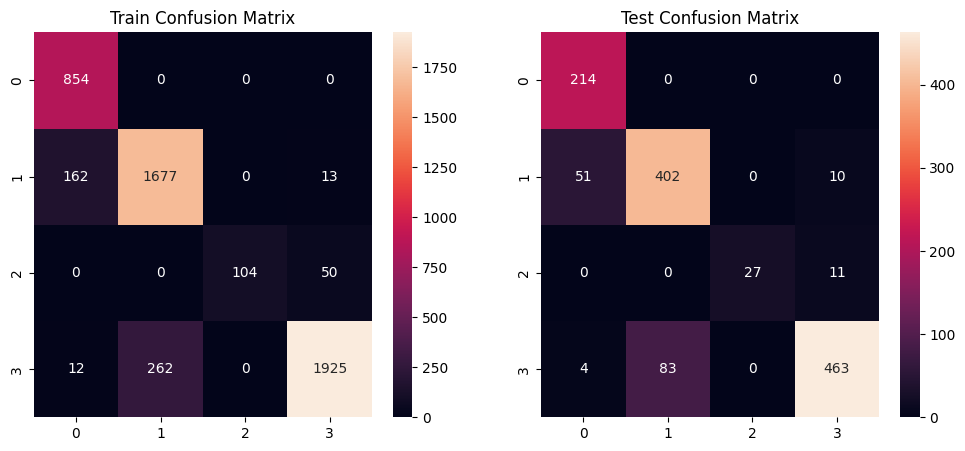

In [203]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.heatmap(confusion_matrix(ytrain, ytrain_pred), annot=True,fmt="d", ax=axes[0])
axes[0].set_title("Train Confusion Matrix")
sns.heatmap(confusion_matrix(ytest, ytest_pred), annot=True, fmt="d", ax=axes[1])
axes[1].set_title("Test Confusion Matrix")
plt.show()

- The worst prediction are from 1 & 2 classes

- Visualize shap waterfall for minority clases 1 and 2

In [187]:
ytrain_pred

array([0, 3, 0, ..., 2, 3, 1])

In [188]:
np.where((ytrain_pred==1))[0][0]

np.int64(4)

In [189]:
model.predict_proba(xtrain)[4]

array([0.01664915, 0.84711885, 0.00127481, 0.13495718], dtype=float32)

In [190]:
explainer = shap.Explainer(model)
shap_values = explainer(xtrain)

print(np.shape(shap_values))

(5059, 18, 4)


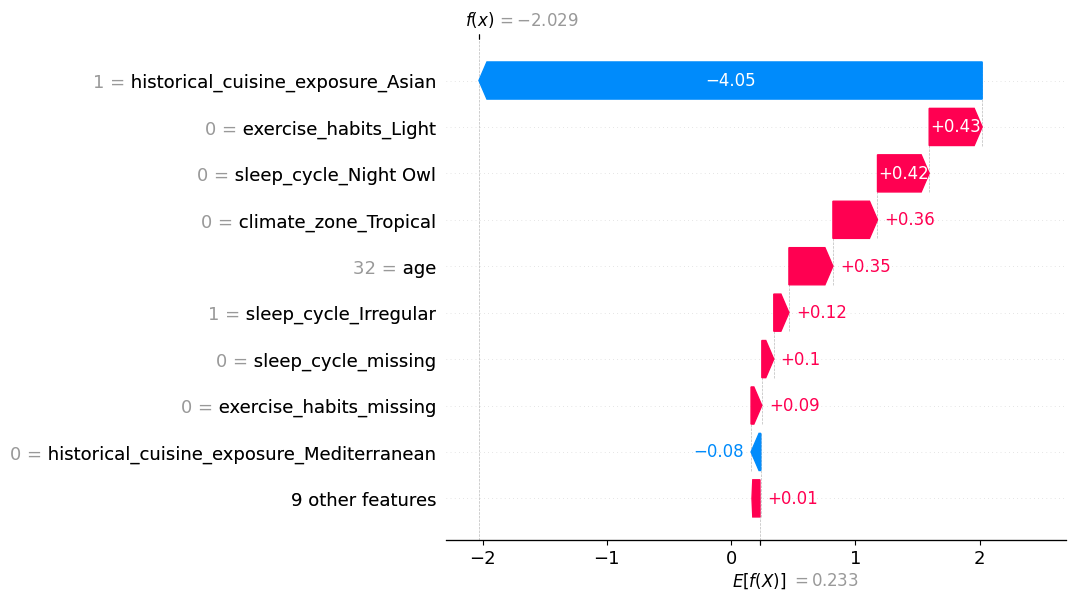

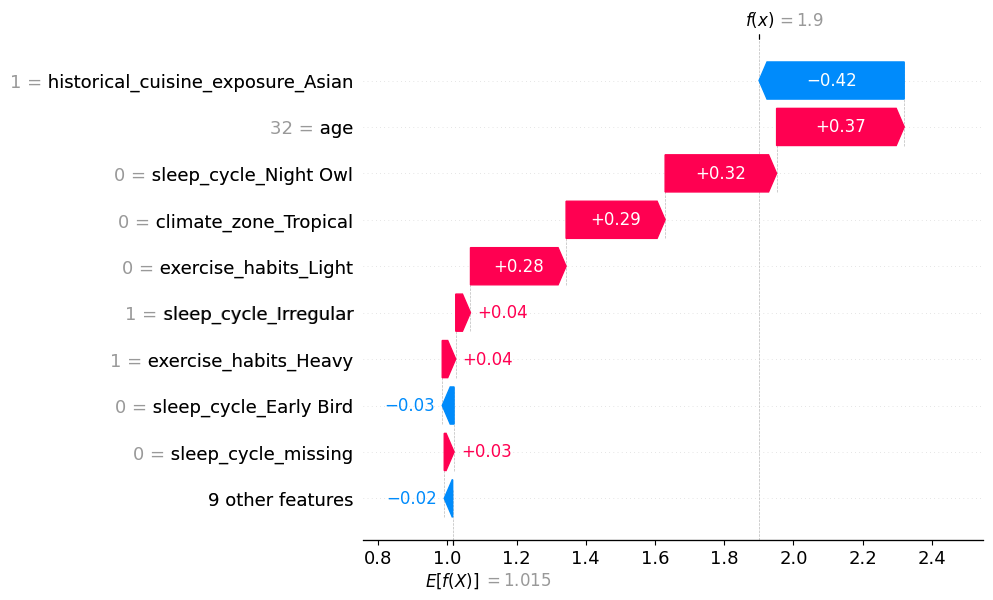

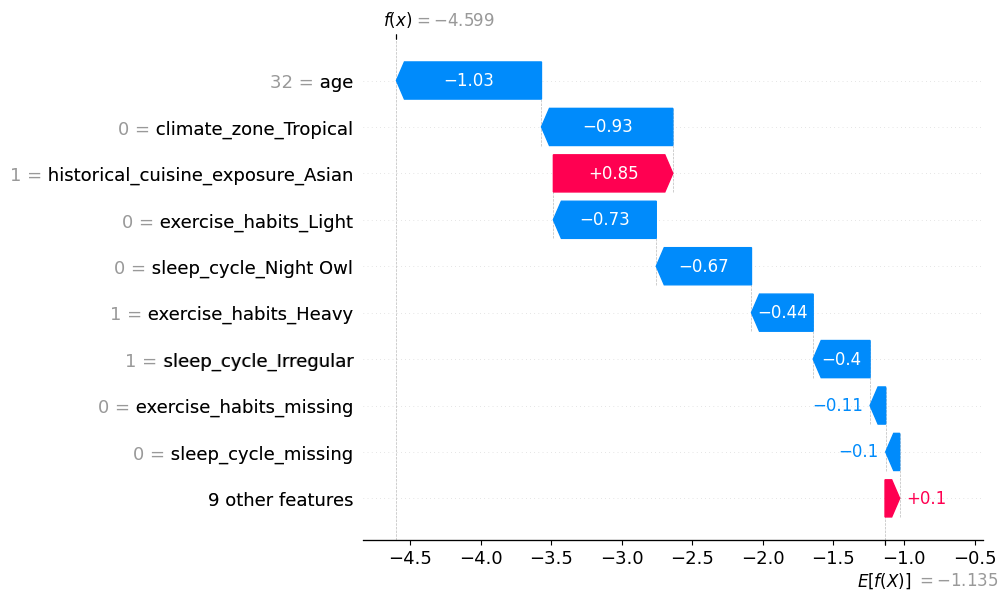

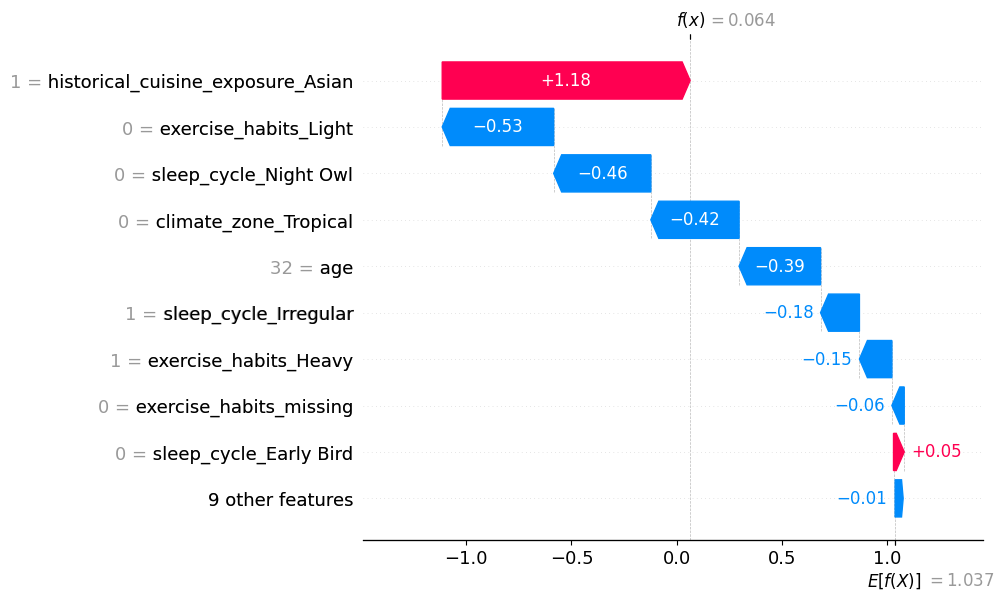

In [191]:
shap.plots.waterfall(shap_values[4, :, 0])
shap.plots.waterfall(shap_values[4, :, 1])
shap.plots.waterfall(shap_values[4, :, 2])
shap.plots.waterfall(shap_values[4, :, 3])

In [192]:
np.where((ytrain_pred==2))[0][0]

np.int64(17)

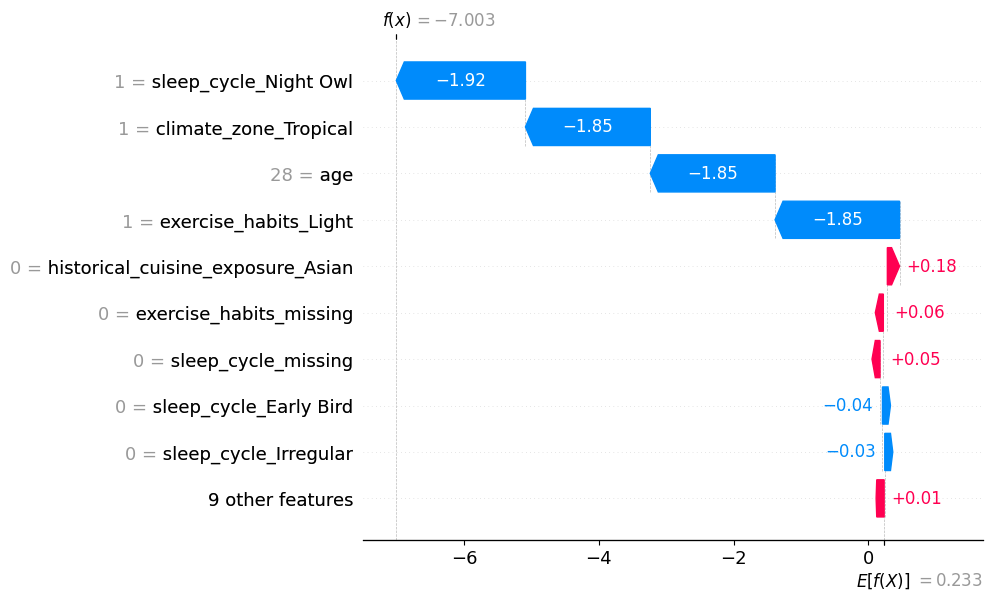

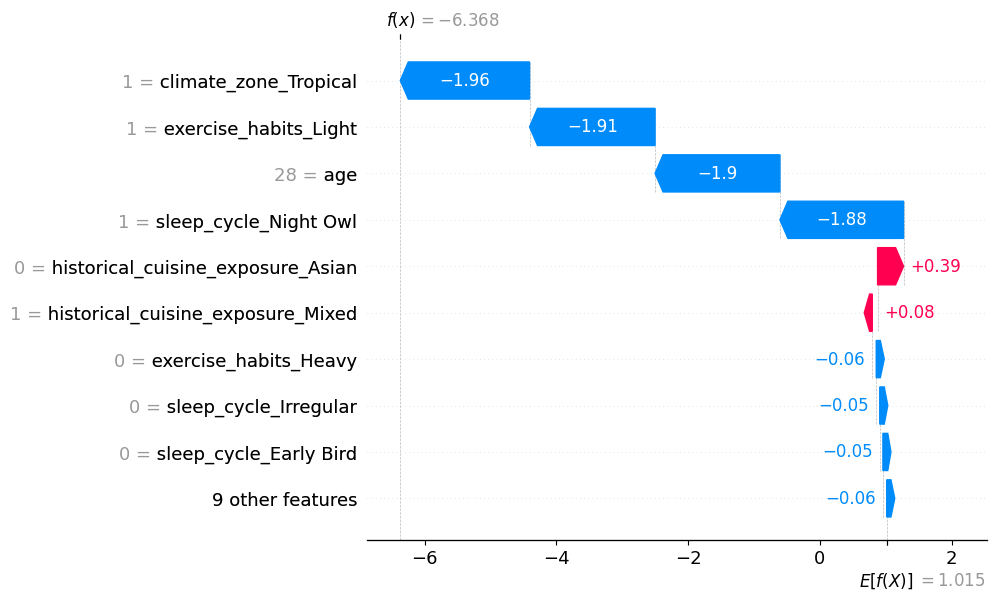

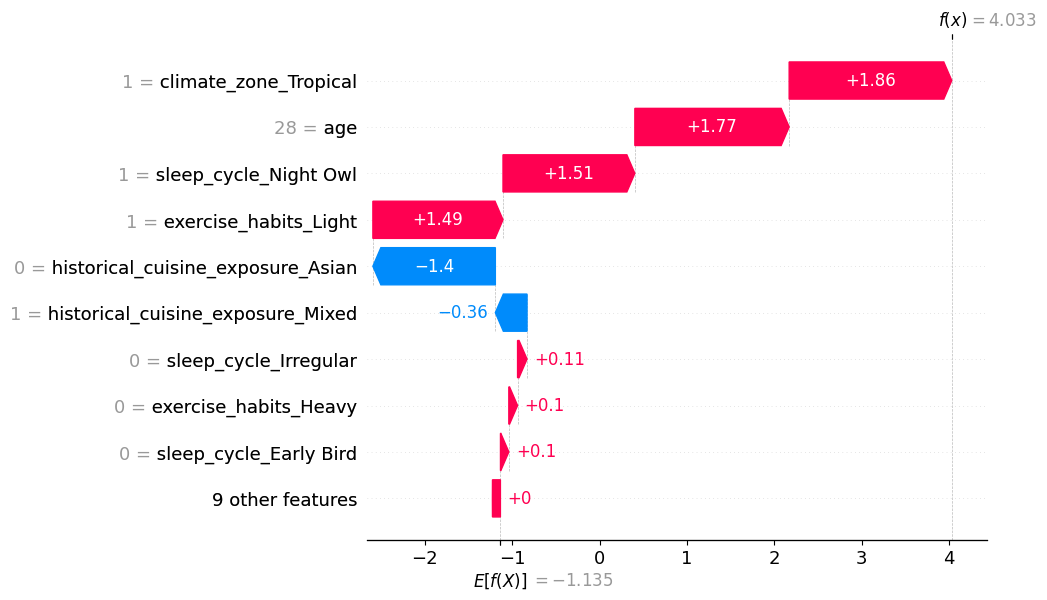

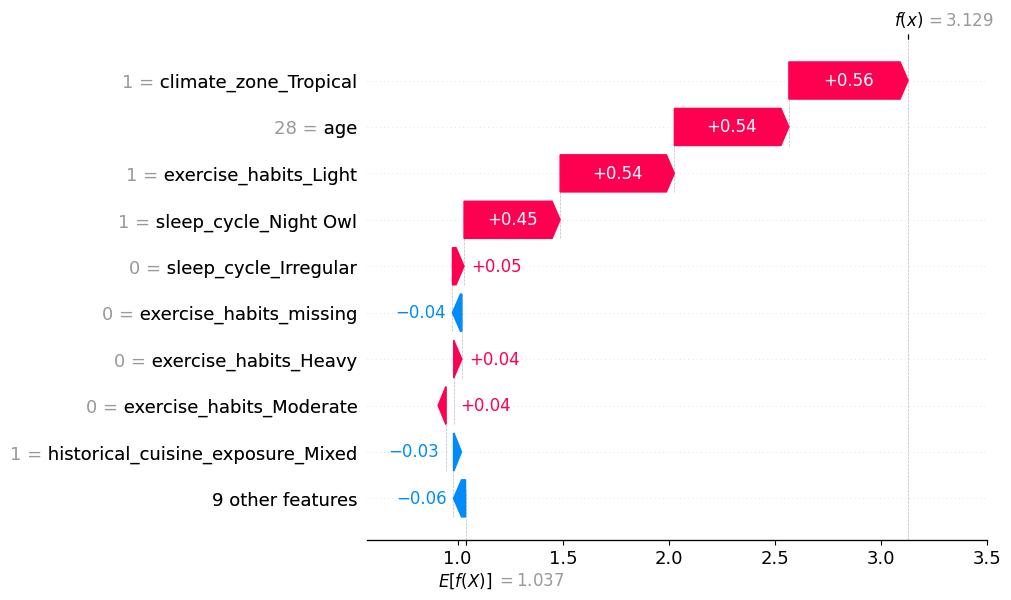

In [193]:
shap.plots.waterfall(shap_values[17, :, 0])
shap.plots.waterfall(shap_values[17, :, 1])
shap.plots.waterfall(shap_values[17, :, 2])
shap.plots.waterfall(shap_values[17, :, 3])

In [194]:
np.where((ytrain_pred==0))[0][0]

np.int64(0)

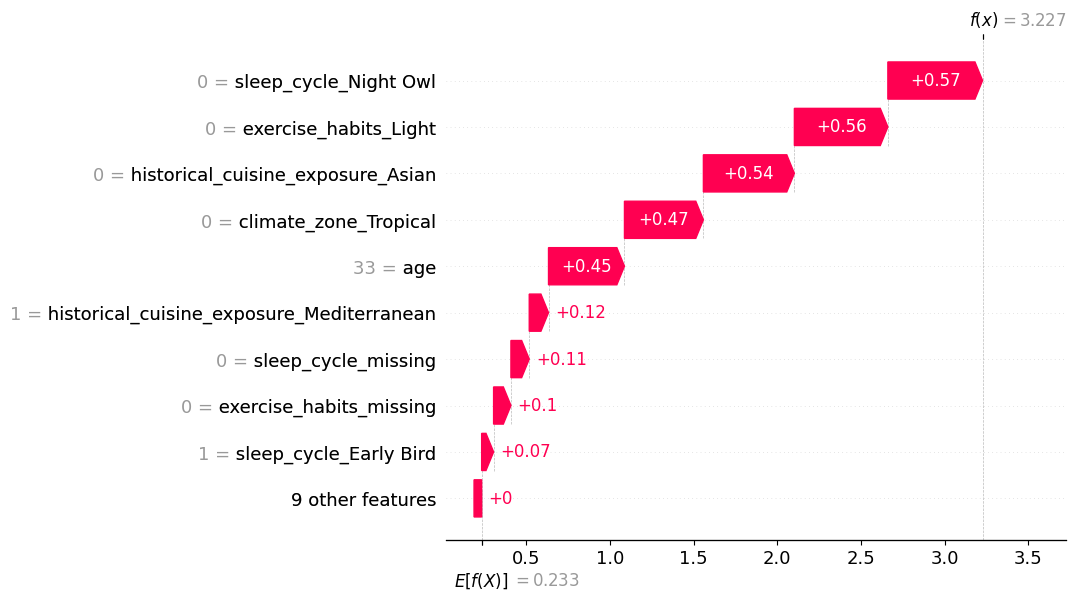

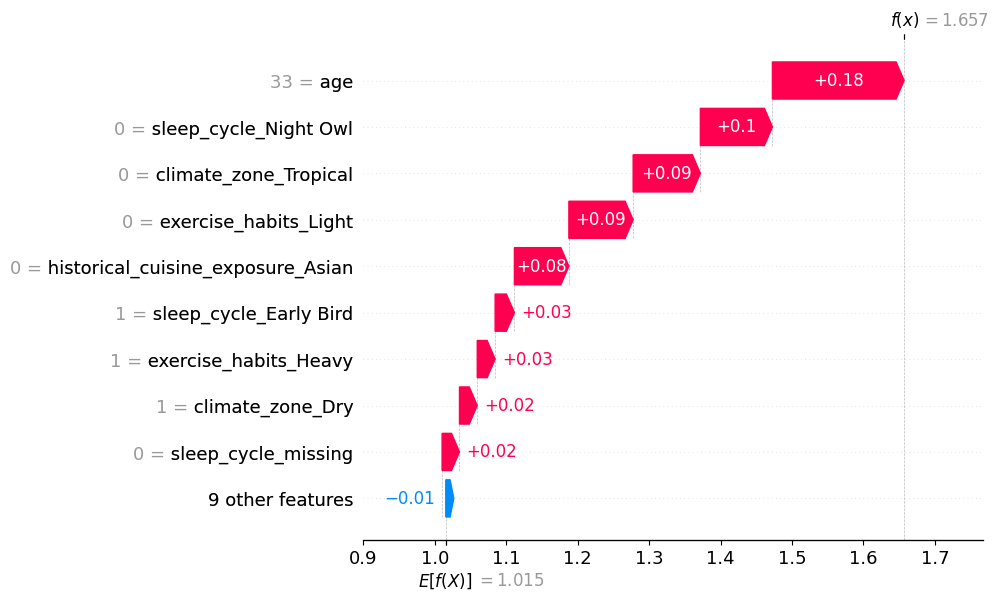

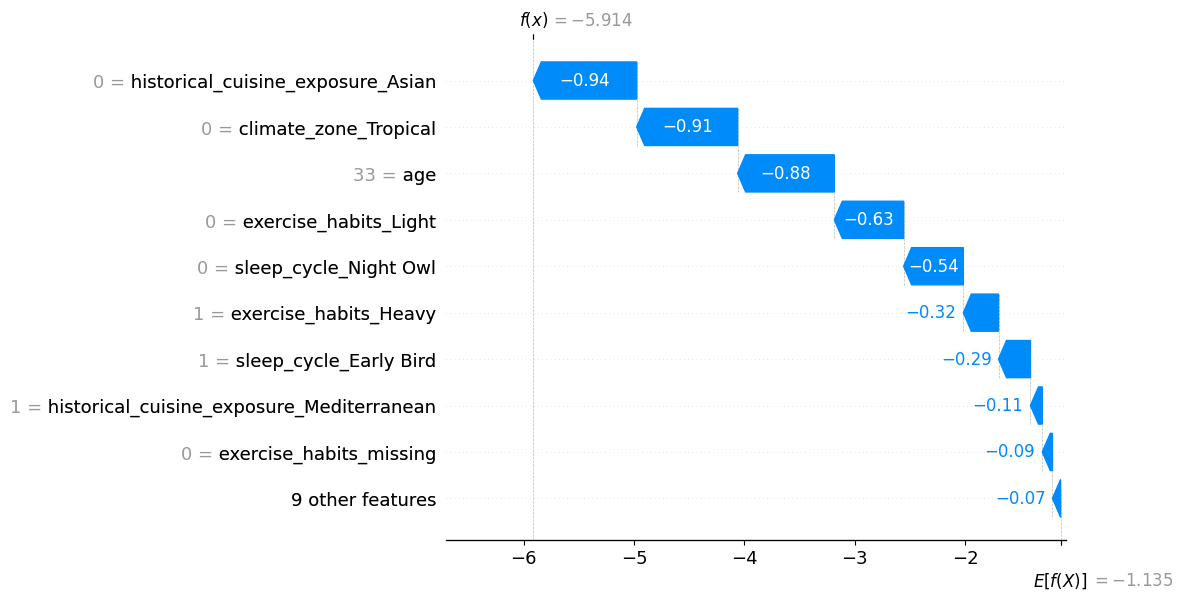

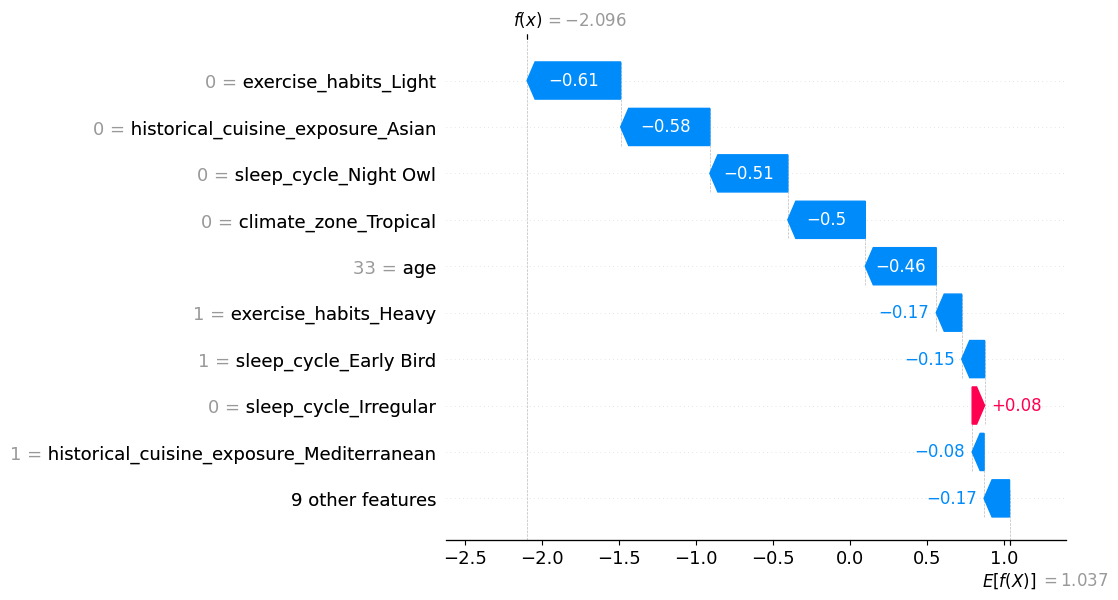

In [195]:
shap.plots.waterfall(shap_values[0, :, 0])
shap.plots.waterfall(shap_values[0, :, 1])
shap.plots.waterfall(shap_values[0, :, 2])
shap.plots.waterfall(shap_values[0, :, 3])

Trying Record 4
- fx for class 1 is the largerst because its the predicted
- historical_cuisine_exposure_Asian is a good classifier for terminatig the majority class of 0
- Age is a good classifier

Trying fro record 17
- fx for class 2 is the largerst because its the predicted
- Climate xone Tropical was the largest contributer & and sleep cycle night owl


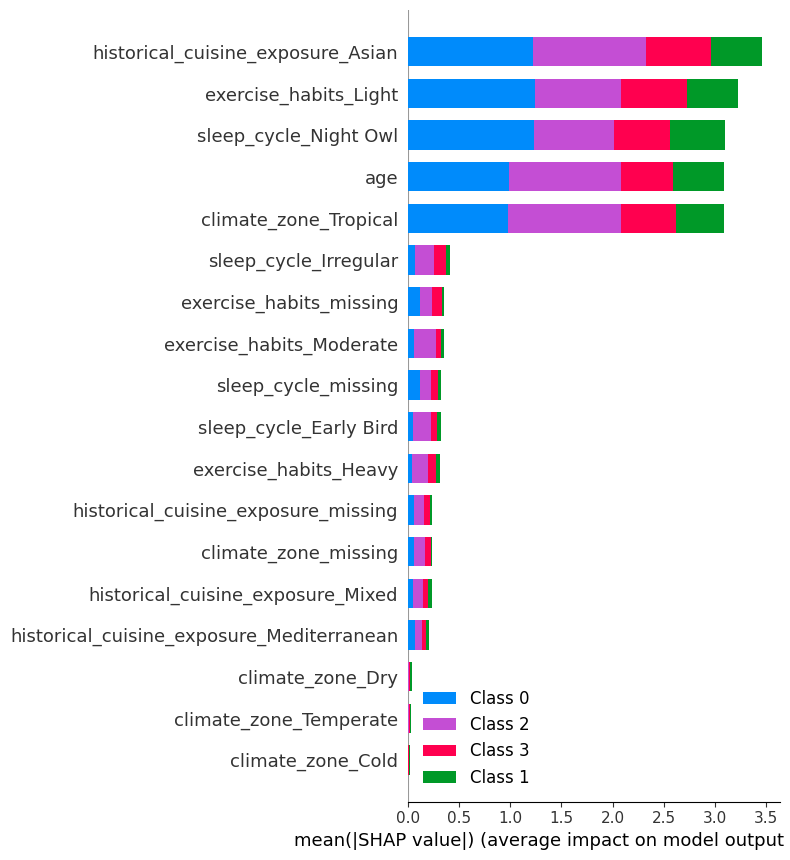

In [182]:
shap.summary_plot(shap_values, xtrain, plot_type="bar")

- The summary plot shows the avarage impact of all features on the mmodel